   ## Setup & Initialisation of levers and uncertainties

In [1]:
from IPython import get_ipython
import time
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'




In [2]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results

from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import pairs_plotting, plotting, plotting_util

import ema_workbench.em_framework.evaluators
from dicemodel.specs import change_fontsize
# from ema_workbench.analysis import feature_scoring
# from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [3]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                             IntegerParameter('vd_switch', 0, 1)
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        # TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR'),
                        TimeSeriesOutcome('SCC')
                        ]


In [4]:
n_scenarios = 2000
n_policies = 50
run = '38_OE'

In [5]:
## Load results
results = load_results(os.path.join(gz_path,'38_OE2000s_50p_.tar.gz'))
experiments, outcomes = results



[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\38_OE2000s_50p_.tar.gz


In [6]:
# for x: Clean experiments (keep only levers, remove policy, scenario, model columns)
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)
cleaned_experiments = experiments.drop(labels= ['policy', 'model',] , axis=1)

# cleaned_experiments
x = cleaned_experiments
#  For y: outcomes is nd-array, PRIM needs 1D

In [10]:

# dropping first two steps (warm up) and last five steps(cooldown)
cleaned_outcome = {}
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

In [11]:
# values for 2300 
end_outcome = {}
for key, value in outcomes.items():
    end_outcome[key] = value[:, -1]  

# np.mean(end_outcome['Damage Growth'], axis =0)


In [14]:
import copy
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)

In [16]:
y_welfare = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 10)

# percentile < 10 = lowest 10%

In [17]:

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim
x = cleaned_experiments
y = y_welfare

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1) #0.1 



In [18]:
box1 = prim_alg.find_box()


[MainProcess/INFO] 100000 points remaining, containing 10000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05841, coverage: 0.5841, density: 1.0 restricted_dimensions: 5


In [19]:
box1.peeling_trajectory


,coverage,density,id,mass,mean,res_dim
0,1.0000,0.100000,0,1.00000,0.100000,0
1,1.0000,0.200000,1,0.50000,0.200000,1
2,1.0000,0.222222,2,0.45000,0.222222,2
3,1.0000,0.246914,3,0.40500,0.246914,2
4,1.0000,0.274348,4,0.36450,0.274348,2
5,1.0000,0.304832,5,0.32805,0.304832,3
6,1.0000,0.342936,6,0.29160,0.342936,3
7,1.0000,0.381039,7,0.26244,0.381039,3
8,1.0000,0.442497,8,0.22599,0.442497,3
9,1.0000,0.508053,9,0.19683,0.508053,3


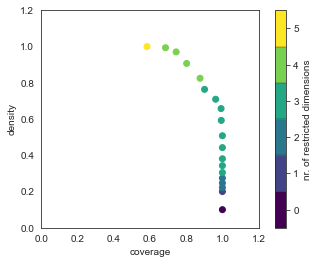

In [24]:
box1.show_tradeoff()
fig = plt.gcf()
# fig.set_size_inches(12,12)
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_wel_tradeoff' + '.png'))


In [23]:
box1.inspect(14)

coverage     0.8765
density     0.82533
id               14
mass         0.1062
mean        0.82533
res_dim           4
Name: 14, dtype: object

               box 14                                           
                  min        max                       qp values
emdd        -0.999058   0.186323                     [-1.0, 0.0]
vd_switch    0.500000   1.000000                     [0.0, -1.0]
miu_period  39.500000  58.000000                     [0.0, -1.0]
sr           0.124329   0.494989  [1.3316240910353313e-53, -1.0]



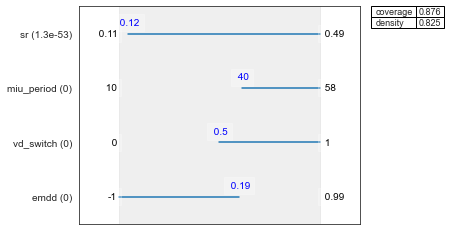

In [25]:
box1.inspect(14, style='graph')
fig = plt.gcf()
# fig.set_size_inches(12,12)
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_wel_id14' + '.png'))

plt.show()


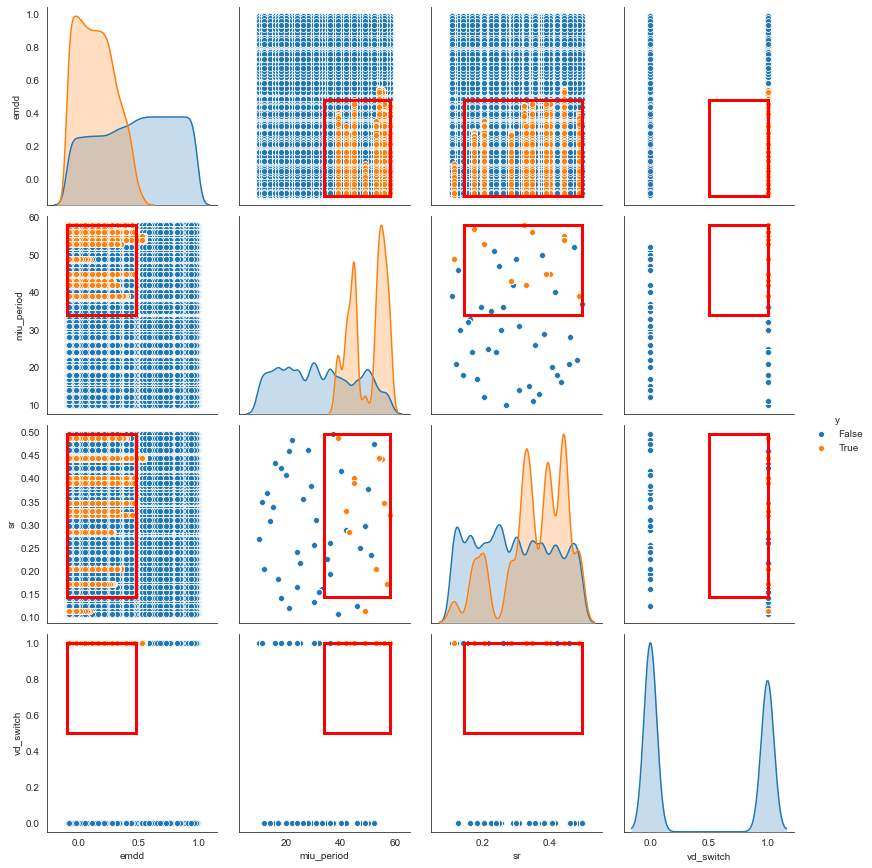

In [22]:
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()


In [23]:
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_welfare_box1' + '.png'))


## PRIM on V(D)

In [37]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)

In [41]:
# Disutility of Damage

data_disutil_dam = np.max(cleaned_outcome['Disutility of Damage'], axis = 1)
y_disutil_dam_high10 = data_disutil_dam > np.percentile(data_disutil_dam, 90)
# y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
#percentile < 80 = lowest 80
#percentile > 80 = highest 20
#percentile > 20 = highest 80

In [42]:

x = cleaned_experiments
y = y_disutil_dam_high10

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1) #0.1 



In [43]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 10000 cases of interest
[MainProcess/INFO] mean: 0.9982517482517482, mass: 0.05148, coverage: 0.5139, density: 0.9982517482517482 restricted_dimensions: 5


,coverage,density,id,mass,mean,res_dim
0,1.0000,0.100000,0,1.00000,0.100000,0
1,1.0000,0.200000,1,0.50000,0.200000,1
2,1.0000,0.222222,2,0.45000,0.222222,2
3,1.0000,0.246914,3,0.40500,0.246914,2
4,1.0000,0.274348,4,0.36450,0.274348,2
5,1.0000,0.304832,5,0.32805,0.304832,3
6,1.0000,0.342936,6,0.29160,0.342936,3
7,1.0000,0.381039,7,0.26244,0.381039,3
8,1.0000,0.442497,8,0.22599,0.442497,3
9,0.9984,0.490952,9,0.20336,0.490952,3


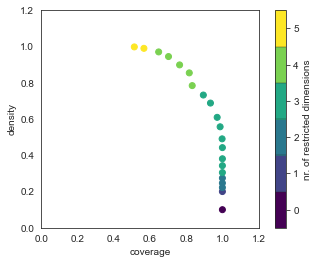

In [44]:
box1.show_tradeoff()
fig = plt.gcf()
# fig.set_size_inches(12,12)
# fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_vd_high20__tradeoff' + '.png'))


In [32]:
# highest 20% V(D) outomes
box1.inspect(9)

coverage     0.86515
density     0.879083
id                 9
mass         0.19683
mean        0.879083
res_dim            3
Name: 9, dtype: object

                box 9                        
                  min        max    qp values
emdd        -0.999058   0.448023  [-1.0, 0.0]
vd_switch    0.500000   1.000000  [0.0, -1.0]
miu_period  32.000000  58.000000  [0.0, -1.0]



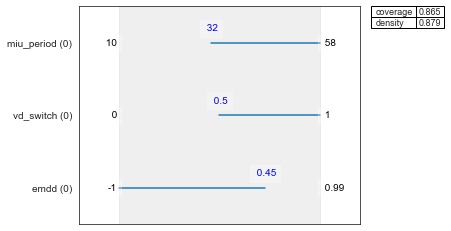

In [33]:
box1.inspect(9, style='graph')
plt.show()


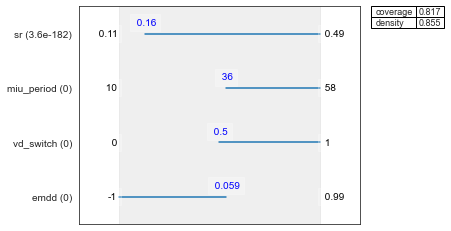

In [46]:
box1.inspect(15, style='graph')
plt.show()


In [45]:
# highest 10% V(D) outomes
box1.inspect(15)

coverage      0.8172
density     0.854991
id                15
mass         0.09558
mean        0.854991
res_dim            4
Name: 15, dtype: object

               box 15                                           
                  min        max                       qp values
emdd        -0.999058   0.059413                     [-1.0, 0.0]
vd_switch    0.500000   1.000000                     [0.0, -1.0]
miu_period  35.500000  58.000000                     [0.0, -1.0]
sr           0.156757   0.494989  [3.554091113639452e-182, -1.0]

